# Co-embedding snATAC-seq and scRNA-seq (ALL scRNA-seq cells, ALL ATAC cells)
- https://github.com/satijalab/seurat/issues/5254
- https://github.com/satijalab/seurat/issues/4874
- https://github.com/stuart-lab/signac/issues/219
- Do not SCTransform snATAC-seq data: https://github.com/satijalab/seurat/issues/3359


Co-embedding notebooks:
- 1) ALL scRNA-seq with snATAC-seq (labeled with ALL scRNA-seq), or
- 2) GFP+ scRNA-seq with snATAC-seq (labeled with GFP+ scRNA-seq)

## Set up correct conda environment

In [1]:
.libPaths()

[1] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [2]:
.libPaths('/home/groups/tttt/xjluo/miniconda3/envs/single_cell_Seurat_v5/lib/R/library')
.libPaths()

[1] "/home/groups/tttt/xjluo/miniconda3/envs/single_cell_Seurat_v5/lib/R/library"
[2] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [3]:
library(tidyverse)
library(viridis)
library(Seurat)
library(Signac)
library(Azimuth)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpointdensity)
library(ggExtra)

set.seed(1234)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=50)
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



Attaching shinyBS

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following ob

In [4]:
sample <- 'E1'

In [5]:
# value is either 'ALL' or 'GFP' depending on the script
all_or_gfp <- 'ALL'

## STEP 0: Paths

In [6]:
data_master_dir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC'

data_master_dir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC"

In [7]:
data_master_dir_old <- '/oak/stanford/groups/tttt/collaboration/jin/240613_ATAC'
rna_path <- paste0(data_master_dir_old, '/', 'RNA', '/', 'ctx.Robj')

rna_path

[1] "/oak/stanford/groups/tttt/collaboration/jin/240613_ATAC/RNA/ctx.Robj"

In [8]:
atac_dir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC'
atac_path <- paste0(atac_dir, '/3_filtered_anchored_to_', all_or_gfp, '_RNA/', sample, ".ATAC.anchored.", all_or_gfp , ".annotated.Seurat.v5.rds")

atac_path

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/3_filtered_anchored_to_ALL_RNA/E1.ATAC.anchored.ALL.annotated.Seurat.v5.rds"

In [9]:
# Define the directory to save plots
plot_save_dir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step3_figures'
plot_save_dir_annotations <- paste0(plot_save_dir, '/', '02_annotation', '/', sample)

plot_save_dir_annotations

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step3_figures/02_annotation/E1"

## STEP 1: Load data

### STEP 1.1 Load RNA object for appropriate condition
- Condition 1: all cells, OR
- Condition 2 : GFP+ sorted only

In [10]:
load(rna_path)

# NOTE: the 'v4' in variable names is just for convenience, since this notebook is adapted from a previous ATAC dataset.
# Seurat v5 is now used.

rna.obj.annotated.Seurat.v4 <- ctx

In [11]:
rna.obj.annotated.Seurat.v4

An object of class Seurat 
32475 features across 7158 samples within 6 assays 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 5 other assays present: ADT, prediction.score.class, prediction.score.cluster, prediction.score.subclass, prediction.score.cross_species_cluster
 5 dimensional reductions calculated: integrated_dr, ref.umap, pca, umap.unintegrated, umap

In [12]:
table(rna.obj.annotated.Seurat.v4$orig.ident)


 all GFP2 
3045 4113 

In [13]:
Idents(rna.obj.annotated.Seurat.v4) <- 'orig.ident'

# Uncomment below line if this notebook focuses on the GFP+ only scRNA-seq experiment
# rna.obj.annotated.Seurat.v4 <- subset(x = rna.obj.annotated.Seurat.v4, idents = c('GFP'))

In [14]:
rna.obj.annotated.Seurat.v4

An object of class Seurat 
32475 features across 7158 samples within 6 assays 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 5 other assays present: ADT, prediction.score.class, prediction.score.cluster, prediction.score.subclass, prediction.score.cross_species_cluster
 5 dimensional reductions calculated: integrated_dr, ref.umap, pca, umap.unintegrated, umap

### STEP 1.2: Load ATAC object (GFP-sorted)

In [15]:
atac.obj.annotated.Seurat.v4 <- readRDS(atac_path)

In [16]:
atac.obj.annotated.Seurat.v4

An object of class Seurat 
301433 features across 2663 samples within 2 assays 
Active assay: ACTIVITY (1528 features, 0 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC
 2 dimensional reductions calculated: lsi, umap

### STEP 1.3: Inspect objects

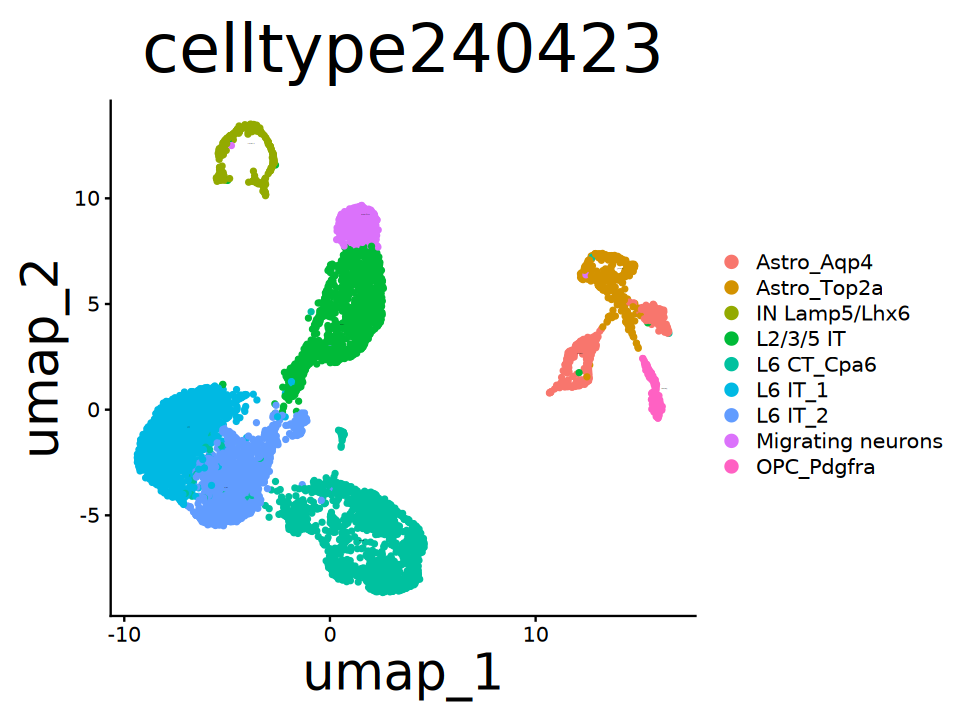

In [17]:
# RNA
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(rna.obj.annotated.Seurat.v4, shuffle=TRUE, label = TRUE, repel = TRUE, pt.size=1, label.size=0, reduction = "umap", group.by = 'celltype240423', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     
     


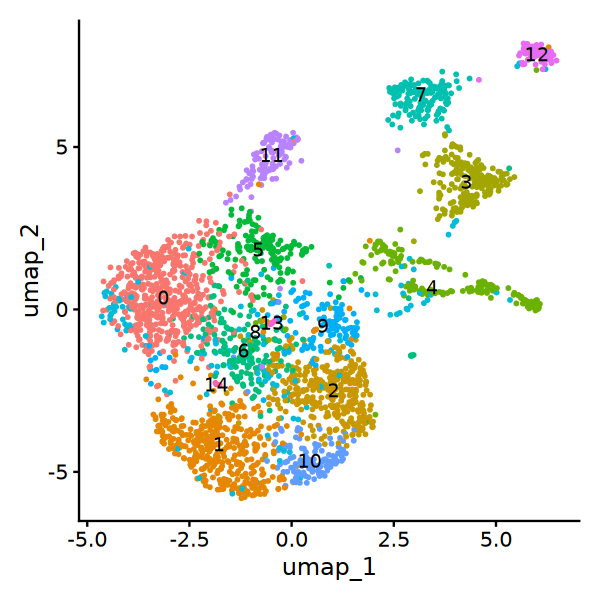

In [18]:
# ATAC
options(repr.plot.width=5, repr.plot.height=5)

DimPlot(object = atac.obj.annotated.Seurat.v4, label = TRUE) + NoLegend()

## STEP 2: Coembed RNA and ATAC

In [19]:
# add 'assay' column
rna.obj.annotated.Seurat.v4$assay <- 'RNA'
atac.obj.annotated.Seurat.v4$assay <- 'ATAC'

atac.obj.annotated.Seurat.v4$celltype240423 <-atac.obj.annotated.Seurat.v4$predicted.id

In [20]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
genes.use <- VariableFeatures(rna.obj.annotated.Seurat.v4)
refdata <- GetAssayData(rna.obj.annotated.Seurat.v4, assay = "RNA", slot = "data")[genes.use, ]

In [21]:
# quantify gene activity
DefaultAssay(atac.obj.annotated.Seurat.v4) <- 'ATAC'
gene.activities <- GeneActivity(atac.obj.annotated.Seurat.v4, features = VariableFeatures(rna.obj.annotated.Seurat.v4))

# add gene activities as a new assay
atac.obj.annotated.Seurat.v4[["ACTIVITY"]] <- CreateAssayObject(counts = gene.activities)

# normalize gene activities
DefaultAssay(atac.obj.annotated.Seurat.v4) <- "ACTIVITY"
atac.obj.annotated.Seurat.v4 <- NormalizeData(atac.obj.annotated.Seurat.v4)
atac.obj.annotated.Seurat.v4 <- ScaleData(atac.obj.annotated.Seurat.v4, features = rownames(atac.obj.annotated.Seurat.v4))

# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = rna.obj.annotated.Seurat.v4, 
                                        query = atac.obj.annotated.Seurat.v4, 
                                        features = VariableFeatures(object = rna.obj.annotated.Seurat.v4),
                                        reference.assay = "RNA", 
                                        query.assay = "ACTIVITY", 
                                        reduction = "cca")

Extracting gene coordinates

Extracting reads overlapping genomic regions

Centering and scaling data matrix

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9744 anchors



In [22]:
# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells.  imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = atac.obj.annotated.Seurat.v4[["lsi"]],
    dims = 2:30)
atac.obj.annotated.Seurat.v4[["RNA"]] <- imputation

Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



In [23]:
coembed <- merge(x = rna.obj.annotated.Seurat.v4, y = atac.obj.annotated.Seurat.v4)

In [24]:
coembed

An object of class Seurat 
333908 features across 9821 samples within 8 assays 
Active assay: RNA (32285 features, 2000 variable features)
 4 layers present: data.Esr1, data.SeuratProject, counts.Esr1, scale.data.Esr1
 7 other assays present: ADT, prediction.score.class, prediction.score.cluster, prediction.score.subclass, prediction.score.cross_species_cluster, ATAC, ACTIVITY

In [25]:
# Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both
# datasets

DefaultAssay(coembed) <- 'RNA'
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30)

Centering data matrix

06:13:23 UMAP embedding parameters a = 0.9922 b = 1.112

06:13:23 Read 9821 rows and found 30 numeric columns

06:13:23 Using Annoy for neighbor search, n_neighbors = 30

06:13:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:13:25 Writing NN index file to temp file /tmp/RtmpCJVQqZ/file17b0f2b6d2e02

06:13:25 Searching Annoy index using 1 thread, search_k = 3000

06:13:32 Annoy recall = 100%

06:13:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

06:13:37 Initializing from normalized Laplacian + noise (using RSpectra)

06:13:38 Commencing optimization for 500 epochs, with 428912 positive edges

06:14:46 Optimization finished



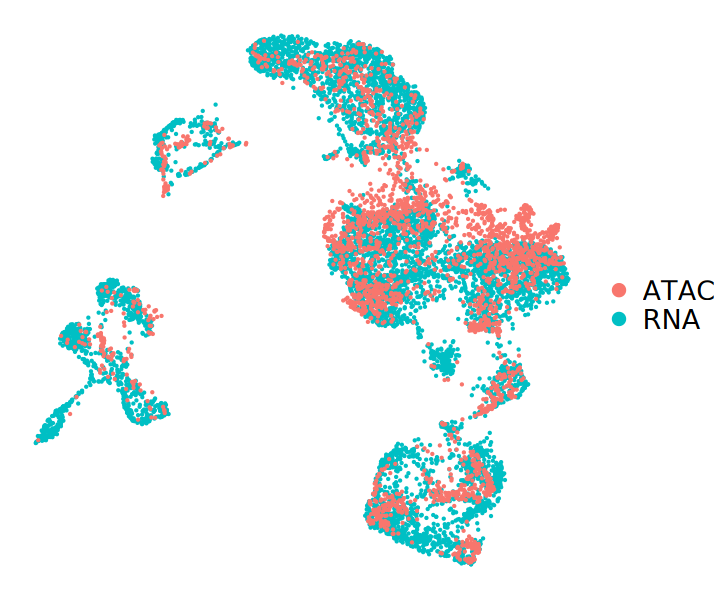

In [26]:
options(repr.plot.width=6, repr.plot.height=5)

## Define a custom theme for the plots
custom_theme <- theme_void() + 
  theme(
    plot.title = element_blank(), # Remove plot title
    axis.title = element_blank(), # Remove axis titles
    axis.text = element_blank(),  # Remove axis text
    axis.ticks = element_blank(), # Remove axis ticks
    legend.text = element_text(size = 16) # Increase legend text size, if applicable
  )

# Create UMAP plot grouped by "assay"
umap_plot_assay <- DimPlot(coembed, group.by = "assay") + 
  custom_theme


# Display the plots
print(umap_plot_assay)


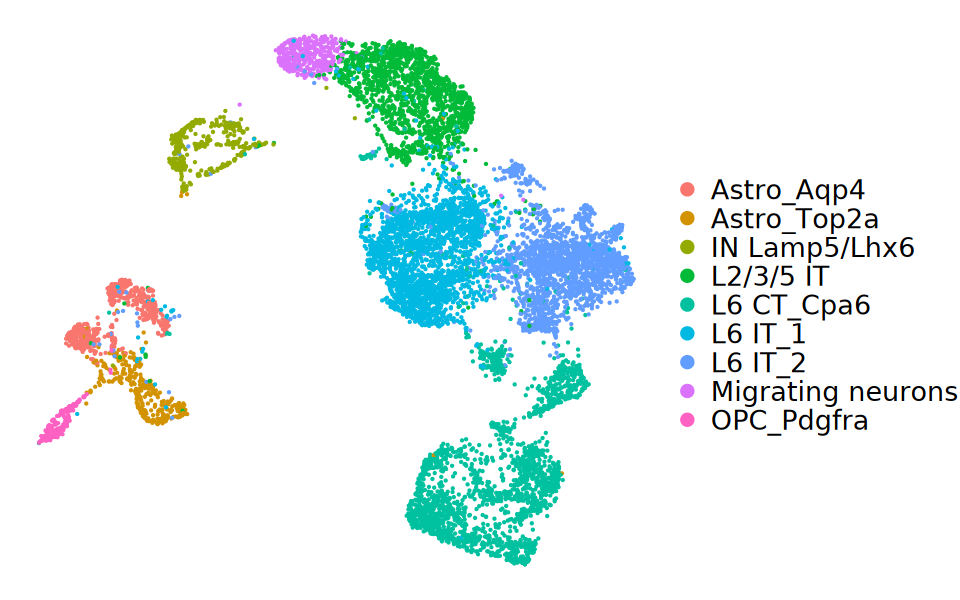

In [27]:
options(repr.plot.width=8, repr.plot.height=5)

# Create UMAP plot grouped by "celltype240423"
umap_plot_celltype <- DimPlot(coembed, group.by = "celltype240423") + 
  custom_theme

print(umap_plot_celltype)

## STEP 3: Save plots

In [28]:
# Ensure the directory exists
if (!dir.exists(plot_save_dir_annotations)) {
  dir.create(plot_save_dir_annotations, recursive=TRUE)
}

In [29]:
# Save the UMAP plot grouped by "assay"
ggsave(file.path(plot_save_dir_annotations, "coembed_umap_assay.pdf"), plot = umap_plot_assay, device = "pdf", dpi = 300, width = 5, height = 4)

# Save the UMAP plot grouped by "celltype240423"
ggsave(file.path(plot_save_dir_annotations, "coembed_umap_celltype.pdf"), plot = umap_plot_celltype, device = "pdf", dpi = 300, width = 6, height = 4)


# END